<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                   Pneumonia Detection
![Pneumonia](https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg)
## Problem Interpretation:
   The goal is to build a pneumonia detection system, to locate the position of inflammation in an chest radiograph (CXR) image. With sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

## Data Interpretation:
  In the data, some of these are labeled **“Not Normal No Lung Opacity”**. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and often times this finding may mimic the appearance of true pneumonia.
 
## What files do I need?
  This is a two-stage challenge. You will need the images for the current stage - provided as **stage_2_train_images.zip** and **stage_2_test_images.zip**. You will also need the training data - **stage_2_train_labels.csv** - and the sample submission **stage_2_sample_submission.csv**, which provides the IDs for the test set, as well as a sample of what your submission should look like. The file **stage_2_detailed_class_info.csv** contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models.

## What should I expect the data format to be?
  The training data is provided as a set of **patientIds** and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height

There is also a binary target column, **Target**, indicating pneumonia or non-pneumonia.

There may be multiple rows per **patientId**.

## DICOM Images
  All provided images are in DICOM format. Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## What am I predicting?
  Here we are predicting whether pneumonia exists in a given image. They do so by predicting bounding boxes around areas of the lung. Samples without bounding boxes are negative and contain no definitive evidence of pneumonia. Samples with bounding boxes indicate evidence of pneumonia.

When making predictions, competitors should predict as many bounding boxes as they feel are necessary, in the format: confidence x-min y-min width height

There should be only ONE predicted row per image. This row may include multiple bounding boxes.

A properly formatted row may look like any of the following.

For patientIds with no predicted pneumonia / bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,

For patientIds with a single predicted bounding box: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100

For patientIds with multiple predicted bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100 0.5 0 0 100 100, etc.

## File descriptions
**stage_2_train.csv** - the training set. Contains patientIds and bounding box / target information.

**stage_2_sample_submission.csv** - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.

**stage_2_detailed_class_info.csv** - provides detailed information about the type of positive or negative class for each image.
## Data fields
patientId _- A patientId. Each patientId corresponds to a unique image.

x_ - the upper-left x coordinate of the bounding box.

y_ - the upper-left y coordinate of the bounding box.

width_ - the width of the bounding box.

height_ - the height of the bounding box.

Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.


## What is pneumonia?


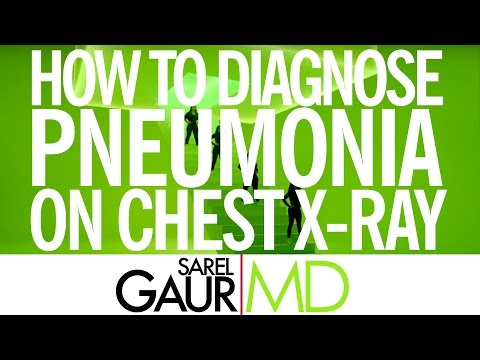

In [19]:

import IPython
IPython.display.YouTubeVideo('mMEen0O6xwc')

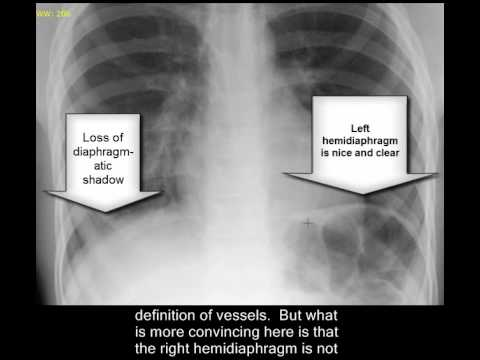

In [ ]:
IPython.display.YouTubeVideo('o5czh4JM0Ho')

## Loading and Preparing the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

In [3]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 stage_2_detailed_class_info.csv        stage_2_train_images
 stage_2_sample_submission.csv	        stage_2_train_labels.csv


In [4]:
import pandas as pd
import numpy as np

In [5]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_class_info = pd.read_csv('stage_2_detailed_class_info.csv')

## EDA and Pre-Processing
  1. Lets review data in  train labels and details of each lebel, to see if there is any missing data
  2. Pre-Process missing data
  3. Although target has two label(0-> not pneumonia, 1->pneumonia), "not pneumonia" category has two category again. Normal & not normal. Need to check if "not pnemonia" category has any impact on final outcome

In [6]:
pd_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


It's clear that there are some patients which does not have any bounding box but there are target as Not Pneumonia.

In [7]:
pd_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


First 4 patients does not  have any pneumonia but 3 patients does not have normal lungs(which is called here as No Lung Opacity).

In [8]:
pd_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [9]:
print("Total lablel patients entry:",pd_label.shape[0])
print("Unique label Patient:",pd_label.patientId.value_counts().shape[0])
print("Total patients entry:",pd_class_info.shape[0])
print('Unique class info patient:',pd_class_info.patientId.value_counts().shape[0])

Total lablel patients entry: 30227
Unique label Patient: 26684
Total patients entry: 30227
Unique class info patient: 26684


In [10]:
#Let concatenate to create a merged data set.
pd_pnm = pd.concat([pd_label,pd_class_info.drop('patientId',1)],1)

In [11]:
pd_pnm.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


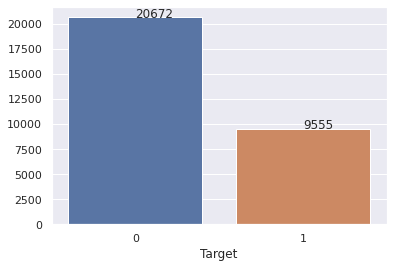

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})

target = pd_pnm.groupby('Target').size()
g = sns.barplot(x=target.index, y=target.array)
x = 0.0
for val in target.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

In [13]:


classlabel = pd_pnm.groupby('class').size()


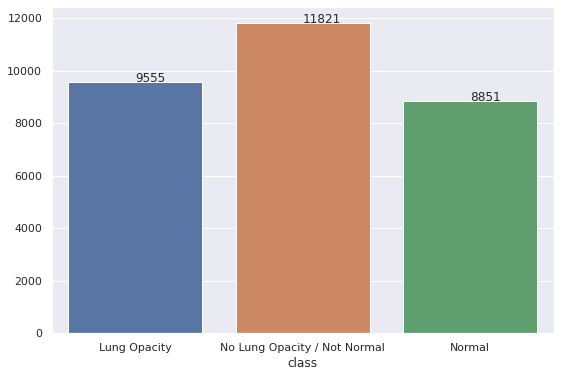

In [14]:
sns.set(rc={'figure.figsize':(9,6)})
g = sns.barplot(x=classlabel.index, y=classlabel.array)
x = 0.0
for val in classlabel.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

In [15]:
#Lets check how many bounding boxes for each patients 
#Even if bouding boxes is NaN, it is counted here.
bbox = pd_pnm.groupby("patientId").size().reset_index(name="BboxNo")
bbox.groupby('BboxNo').size().reset_index(name='Patient Count')

,BboxNo,Patient Count
0,1,23286
1,2,3266
2,3,119
3,4,13


                          class  Target  Patient_Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851


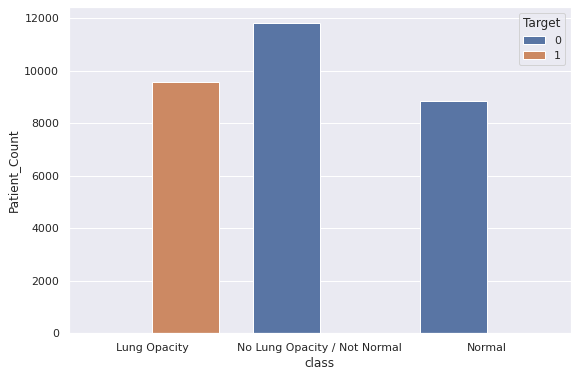

In [16]:
#Lets check how  each class(3) is distributed among each target(0,1))
class_target = pd_pnm.groupby(['class','Target']).size().reset_index(name='Patient_Count')
print(class_target.head())
# class_target['class']
sns.barplot(x="class",y ="Patient_Count",hue='Target',data=class_target)

### Study CXR image

  @TODO Describe how dicom files are stored

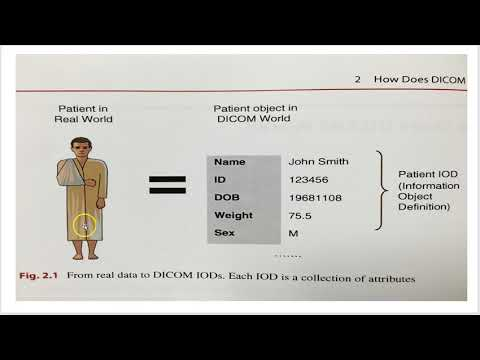

In [20]:
IPython.display.YouTubeVideo('eCECXr-HxVs')

In [18]:
pip install pydicom

     |████████████████████████████████| 35.5MB 1.4MB/s 


In [24]:
import pydicom
import matplotlib.pyplot as plt

In [25]:
import glob
train_dcms = glob.glob('stage_2_train_images/*.dcm')
test_dcms = glob.glob('stage_2_test_images/*.dcm')

In [26]:
print("No of Train Image:{}, No pf Test Image:{}".format(len(train_dcms),len(test_dcms)))
train_dcms[0]

No of Train Image:26684, No pf Test Image:3000


'stage_2_train_images/f6ba1426-6cf9-42a8-ab35-ab0dcead78e2.dcm'

In [27]:
#lets print a sample image
dataset = pydicom.dcmread(train_dcms[0])
print(dataset)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [28]:

for d in dataset:
  pass
for t ,e in dataset.items():
  print("keyword=",e.keyword)

keyword= SpecificCharacterSet
keyword= SOPClassUID
keyword= SOPInstanceUID
keyword= StudyDate
keyword= StudyTime
keyword= AccessionNumber
keyword= Modality
keyword= ConversionType
keyword= ReferringPhysicianName
keyword= SeriesDescription
keyword= PatientName
keyword= PatientID
keyword= PatientBirthDate
keyword= PatientSex
keyword= PatientAge
keyword= BodyPartExamined
keyword= ViewPosition
keyword= StudyInstanceUID
keyword= SeriesInstanceUID
keyword= StudyID
keyword= SeriesNumber
keyword= InstanceNumber
keyword= PatientOrientation
keyword= SamplesPerPixel
keyword= PhotometricInterpretation
keyword= Rows
keyword= Columns
keyword= PixelSpacing
keyword= BitsAllocated
keyword= BitsStored
keyword= HighBit
keyword= PixelRepresentation
keyword= LossyImageCompression
keyword= LossyImageCompressionMethod
keyword= PixelData


In [29]:
# for timage in train_dcms:
timage = train_dcms[0]
patiendIDs = [os.path.basename(img).split('.')[0] for img in train_dcms]
len(patiendIDs) 

26684

In [30]:
#create a datafram of patientID & path. This will be merged with bounding box dataset
df_image = pd.DataFrame({"patientId":patiendIDs,"path":train_dcms})

In [31]:
df_image.sample(5)

,patientId,path
17302,64febd26-2c07-4e4b-a71d-e55d856ed00e,stage_2_train_images/64febd26-2c07-4e4b-a71d-e...
11872,9d45a2b7-6457-46c2-97c6-2bed3a214a80,stage_2_train_images/9d45a2b7-6457-46c2-97c6-2...
3613,e3961779-7dd7-487c-956e-2f674e9b5c71,stage_2_train_images/e3961779-7dd7-487c-956e-2...
16132,7de9b008-f6a8-4101-965d-8590ceaa808a,stage_2_train_images/7de9b008-f6a8-4101-965d-8...
18722,601ee9ee-e04c-4940-8343-33ebf56e69b0,stage_2_train_images/601ee9ee-e04c-4940-8343-3...


In [32]:
#Merge merge bounding box dataset with image dataset
# first merge pd_pnm with bbox dataset
pd_bbox_pnm = pd.merge(pd_pnm,bbox,on='patientId')
df_final = pd.merge(pd_bbox_pnm,df_image,on='patientId',how='left')
print(df_final.shape[0])
df_final.head(6)

30227


,patientId,x,y,width,height,Target,class,BboxNo,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...


In [33]:

def xray(filename):
  dataset = pydicom.dcmread(filename)
  
  # print(type(dataset))
  print()
  print("Filename.........:", filename)
  print("Storage type.....:", dataset.SOPClassUID)
  print()

  pat_name = dataset.PatientName
  display_name = pat_name.family_name + ", " + pat_name.given_name
  print("Patient's name...:", display_name)
  print("Patient id.......:", dataset.PatientID)
  print("Modality.........:", dataset.Modality)
  print("Study Date.......:", dataset.StudyDate)
  print("Study Date.......:", dataset.StudyDate)
  print("Patient Sex......:",dataset.PatientSex)
  print("Patient Age......:",dataset.PatientAge)
  print("Patient Body Part:",dataset.BodyPartExamined)
  print("Patient View Posi:",dataset.ViewPosition)
  if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

  
  print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

  plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
  plt.show()

In [34]:
def showXray(row):
  rw = df_final.iloc[row]
  patID = rw.patientId
  dicomfile = rw.path
  title = rw['class']
  plt.title(title)
  xray(dicomfile)



Filename.........: stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 51
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)


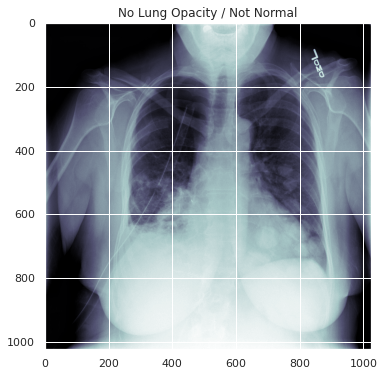

In [35]:
#Lets see xray for Not Normal but no Pneumonia case
showXray(0)


Filename.........: stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, 
Patient id.......: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: M
Patient Age......: 28
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 155284 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)


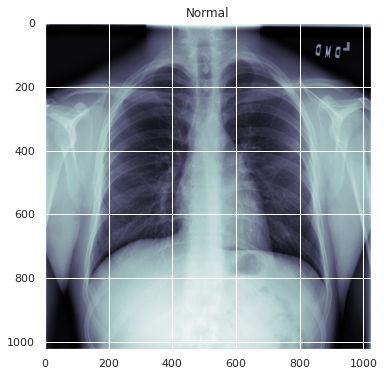

In [36]:
#Lets observe absolutely Normal & no Pneumonia case
showXray(3)


Filename.........: stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 00436515-870c-4b36-a041-de91049b9ab4, 
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 32
Patient Body Part: CHEST
Patient View Posi: AP
Image size.......: 1024 x 1024, 119382 bytes
Pixel spacing....: [0.139, 0.139]
Slice location...: (missing)


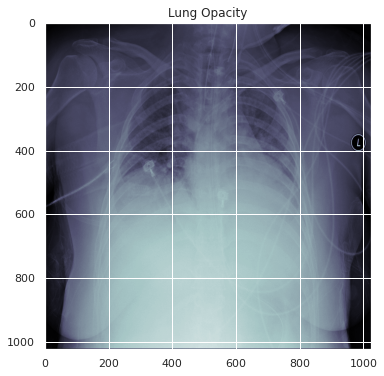

In [37]:
#Lets observe Lung Opacity & hence Pneumonia case
showXray(4)

@TODO Analysis of 3 classes visualization

@TODO add analysis of metadata, like age, sex, viewposition etc

### Show the bounding box
All xray does not have bounding box.
There are maximum of 4 bounding box for a given x-ray

@TODO Dealing with missing bbox


In [44]:
df_pneumonia = df_final[df_final.Target == 1]


,patientId,x,y,width,height,Target,class,BboxNo,path
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,stage_2_train_images/00704310-78a8-4b38-8475-4...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,stage_2_train_images/00704310-78a8-4b38-8475-4...
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,2,stage_2_train_images/00aecb01-a116-45a2-956c-0...


In [54]:
bbox_map = {}
for n, row in df_pneumonia.iterrows():
  pid = row['patientId']
  if pid not in bbox_map:
    bbox_map[row.patientId] = {'path':row['path'], "bboxes":[] }
  bbox_map[pid]['bboxes'].append([row['y'], row['x'], row['height'], row['width']])

In [55]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985']

{'bboxes': [[318.0, 316.0, 478.0, 170.0], [375.0, 660.0, 402.0, 146.0]],
 'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'}

In [70]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('bboxes')


[[318.0, 316.0, 478.0, 170.0], [375.0, 660.0, 402.0, 146.0]]

In [98]:
def drawbbox(pid):
  dcm = pydicom.read_file(pid.get('path'))
  pixel = dcm.pixel_array
  pixel = np.stack([pixel] * 3, axis=2) #Convert into 3 channel
  for box in pid['bboxes']:
    box = [int(b) for b in box]
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
    rgb = np.floor(np.random.rand(3) * 256).astype('int')
    # print(rgb)
    stroke = 6
    pixel[y1:y1 + stroke, x1:x2] = rgb
    pixel[y2:y2 + stroke, x1:x2] = rgb
    pixel[y1:y2, x1:x1 + stroke] = rgb
    pixel[y1:y2, x2:x2 + stroke] = rgb
  plt.imshow(pixel, cmap=plt.cm.gist_gray)
  plt.axis('off')

[243   0  79]
[ 13  31 117]


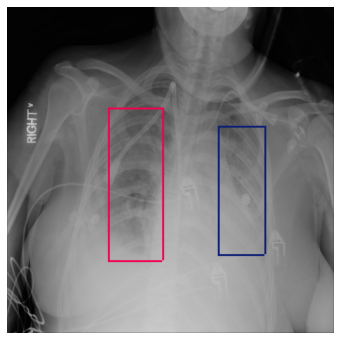

In [99]:
drawbbox(bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'])

In [87]:
set(df_pneumonia[df_pneumonia.BboxNo == 4].patientId)


{'0ab261f9-4eb5-42ab-a9a5-e918904d6356',
 '0d5bc737-03de-4bb8-98a1-45b7180c3e0f',
 '0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d',
 '1bf08f3b-a273-4f51-bafa-b55ada2c23b5',
 '1c44e0a4-4612-438f-9a83-8d5bf919cb67',
 '31764d54-ea3b-434f-bae2-8c579ed13799',
 '3239951b-6211-4290-b237-3d9ad17176db',
 '32408669-c137-4e8d-bd62-fe8345b40e73',
 '349f10b4-dc3e-4f3f-b2e4-a5b81448ce87',
 '76f71a93-8105-4c79-a010-0cfa86f0061a',
 '7d674c82-5501-4730-92c5-d241fd6911e7',
 '8dc8e54b-5b05-4dac-80b9-fa48878621e2',
 'ee820aa5-4804-4984-97b3-f0a71d69702f'}

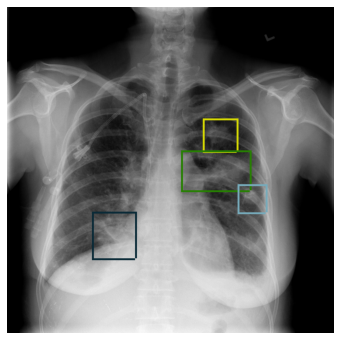

In [88]:
drawbbox(bbox_map['0ab261f9-4eb5-42ab-a9a5-e918904d6356'])

### Handling missing bounding box

In [97]:
#Check if there is any Target(non-pneumonia case) with bounding box
df_final[(np.isnan(df_final.x) == False) & (df_final.Target == 0)]

,patientId,x,y,width,height,Target,class,BboxNo,path


So there is no data having bounding box but it is not pneumonia case.

So to determine if the given xray has any pneumonia characteristics or opacity  we can approach the problem in below  steps.

1. Given any xray build basic CNN model which can try to find any inherent pattern for pneumonia without any bounding box. This is like **object recognition with classification**
2. Detection of bounding box using various **Object recognition with localization** algorithms if the image has any pneominia. Also use **Object detection** technique incase there is multiple location of pneumonia in given xray.
3. We can go further to apply **image segmentation** algorithm like "Mask R-CNN" to show pixels which belong to pneumonia opacity symtoms.

